In [1]:
import shutil, os
import matplotlib.pyplot as plt
import numpy as np
import detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_train,grab_valid

reprocess_results=False

In [2]:
try:
    DatasetCatalog.register("rpd_valid", grab_valid)
except:
    print('Already registered.')
    #do nothing
try:
    DatasetCatalog.register("rpd_train", grab_train)
except:
    print('Already registered.')
    #do nothing
try:
    MetadataCatalog.get("rpd_valid").thing_classes = ["rpd"]
except:
    print('Already registered.')
    #do nothing
try:
    MetadataCatalog.get("rpd_train").thing_classes = ["rpd"]   
except:
    print('Already registered.')
    #do nothing

In [3]:
#predict
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file('configs/working')
#really low iou for nms in order to separate out lesions
cfg.merge_from_list(["MODEL.WEIGHTS", "output_dummy/model_final.pth",
                     "MODEL.ROI_HEADS.NMS_THRESH_TEST",".01",
                     "MODEL.ROI_HEADS.SCORE_THRESH_TEST",".001",
                     "OUTPUT_DIR", "output_dummy/results"])
#print(cfg.dump())  # print formatted configs
print(cfg.MODEL.ROI_HEADS.dump())
print(cfg.MODEL.WEIGHTS)
print(cfg.OUTPUT_DIR)

dataset_name = "rpd_valid"

BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES:
- p2
- p3
- p4
- p5
IOU_LABELS:
- 0
- 1
IOU_THRESHOLDS:
- 0.5
NAME: StandardROIHeads
NMS_THRESH_TEST: 0.01
NUM_CLASSES: 1
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: true
SCORE_THRESH_TEST: 0.001

output_dummy/model_final.pth
output_dummy/results


In [4]:
if reprocess_results:
    #build model
    from detectron2.modeling import build_model
    model = build_model(cfg)  # returns a torch.nn.Module
    from detectron2.checkpoint import DetectionCheckpointer
    DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS);  # load a file, usually from cfg.MODEL.WEIGHTS
    model.eval(); #set model in evaluation mode

    from detectron2.data import build_detection_test_loader
    myloader = build_detection_test_loader(cfg,dataset_name)

    from plain_train_net import EvaluateClass
    myeval = EvaluateClass(
        dataset_name, cfg.OUTPUT_DIR,iou_thresh = .2,prob_thresh=0.5)
    from detectron2.evaluation import inference_on_dataset
    results_i = inference_on_dataset(model, myloader, myeval)
else:
    from plain_train_net import EvaluateClass
    myeval = EvaluateClass(
        dataset_name, cfg.OUTPUT_DIR,iou_thresh = .2,prob_thresh=0.5,evalsuper=False)
    myeval.evaluate()
    
myeval.summarize_scalars()

Using previously cached COCO format annotations at 'output_dummy/results/rpd_valid_coco_format.json'. You need to clear the cache file if your dataset has been modified.


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Calculated metrics for 1176 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.01s).


{'dataset': 'rpd_valid',
 'precision': 0.7043618739903069,
 'recall': 0.77,
 'fpr': 0.0384995064165844,
 'iou': 0.2,
 'probability': 0.5}

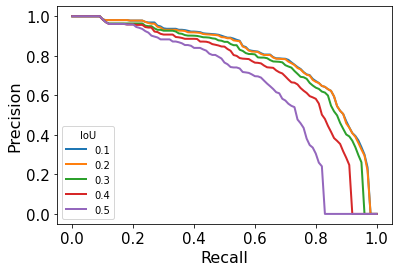

In [5]:
myeval.plot_PRcurve()

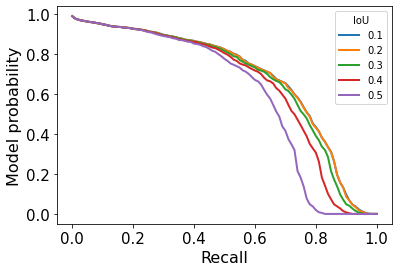

In [6]:
myeval.plot_recall_vs_prob()

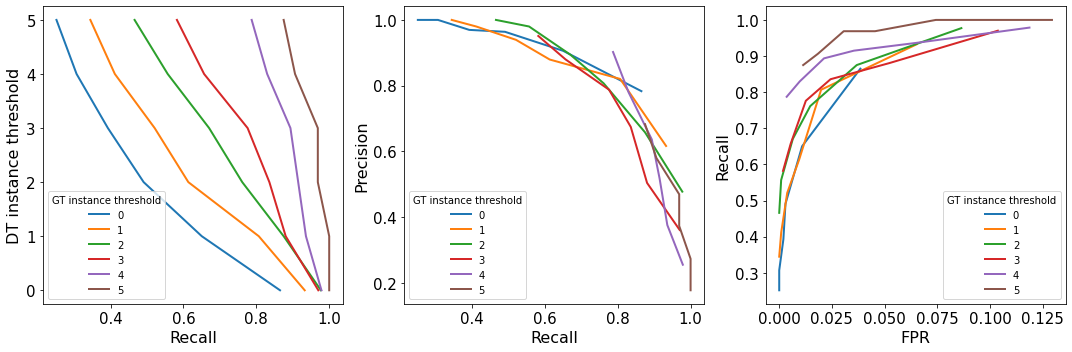

In [54]:
myeval.build_dfimg()
df = myeval.dfimg
inst = list(range(0,6))
#inst = [5]
rc = np.zeros((len(inst),))
pr = np.zeros((len(inst),))
fpr = np.zeros((len(inst),))

fig, ax = plt.subplots(1,3,figsize = [15,5])
for j,gt_thresh in enumerate(inst):
    for i,dt_thresh in enumerate(inst):
        gt = df.gt_instances>gt_thresh
        dt = df.dt_instances>dt_thresh
        rc[i] = (gt&dt).sum()/gt.sum()
        pr[i] = (gt&dt).sum()/dt.sum()
        fpr[i] = ((~gt)&(dt)).sum()/((~gt).sum())
    ax[1].plot(rc,pr,label=gt_thresh)
    ax[0].plot(rc,inst,label=gt_thresh)
    ax[2].plot(fpr,rc,label=gt_thresh)
    
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend(title='GT instance threshold')

ax[0].set_xlabel('Recall')
ax[0].set_ylabel('DT instance threshold')
ax[0].legend(title='GT instance threshold')

ax[2].set_ylabel('Recall')
ax[2].set_xlabel('FPR')
ax[2].legend(title='GT instance threshold')
plt.tight_layout()

In [53]:
print(pr,rc,fpr)

[0.68292683] [0.875] [0.01136364]


In [ ]:
#plot scatter plot as before of gt_pxs vs dt_pxs....extend to relative error between the two vs gt_pxs or dt_pxs

In [7]:
import pandas as pd
newdf = pd.DataFrame([idx.strip('.png').split('_') for idx in df.index],columns=['ptid','eye','scan'],index = df.index)
df = df.merge(newdf,how='inner',left_index=True,right_index=True)

In [8]:
ImgIds = np.abs(df.gt_xpxs-df.dt_xpxs).sort_values(ascending=False).index[0:10].values

In [9]:
from plain_train_net import OutputVis
vis = OutputVis(dataset_name,cfg,0.5)
#vis.output_to_pdf(ImgIds,os.path.join(cfg.OUTPUT_DIR,'top10_xpxs_err.pdf'),dfimg =myeval.dfimg )

In [10]:
dfpts = df.groupby(['ptid','eye'])['gt_instances','gt_pxs','gt_xpxs','dt_instances','dt_pxs','dt_xpxs'].sum()
pd.set_option('display.max_rows',500)
dfpts

/root/miniconda3/envs/detectron/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


gt_instances   gt_pxs  gt_xpxs  dt_instances   dt_pxs  dt_xpxs
ptid   eye                                                                
101109 OD          153.0  29794.0   5671.0         135.0  28061.0   4962.0
101113 OD           30.0   6590.0   1093.0          32.0   7478.0   1201.0
       OS          117.0  43470.0   5951.0         149.0  44154.0   6430.0
101301 OD           62.0  18548.0   2879.0          72.0  14402.0   2379.0
102044 OD          117.0  31163.0   4702.0         122.0  26458.0   4066.0
       OS           82.0  25493.0   3585.0          80.0  18217.0   2776.0
104056 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           1.0     94.0     21.0
104057 OD            0.0      0.0      0.0           1.0    116.0     26.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104060 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104061 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           2.0    463.0     68.0
104063 OD            0.0      0.0      0.0           9.0   1694.0    277.0
       OS            0.0      0.0      0.0          10.0   2575.0    402.0
104064 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104068 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
105009 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
105011 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           2.0    228.0     29.0